In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin

import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import hankel
from scipy.linalg import toeplitz
from scipy.signal import lfilter

from numpy.linalg import pinv

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib.pyplot as plt
import numpy as np

import wave

import colorednoise as cn
#from matplotlib import pylab as plt

import sounddevice as sd
from scipy.io.wavfile import write

from tqdm import tqdm
import time

import pathlib
from util.util import load_data_json, to_db
from expr.util import load_analysis

%matplotlib inline

In [2]:
def nextpow2(i):
    n = 1
    while n < i:
        n *= 2
    return n

> ## Signal Synthesis

> #### Synthesis Function

This function synthesizes a signal following the exponential sinusoidal model (ESM) with a possible vibrato effect (FM) and/or noise. The noise can be set to white, pink, or red, and the signal-to-noise ratio (SNR) can be controlled.

In [3]:
# This function synthesizes a sinusoidal signal, with set frequencies, amplitudes, initial phases, and damping factors
# with optional vibrato effect (FM) and noise (white, pink, or red)

def synthesize(N: int, delta: np.ndarray, f: np.ndarray, a: np.ndarray, phi : np.ndarray,
    f_m : float = 0, mod_index : float = 0, noise_index : int = 0, sin_to_noise : int = 0):
    # input
        # N: length of the signal (discrete)
        # delta: array of damping factors
        # f: array of normalized frequencies
        # a: array of real amplitudes
        # phi: array of initial phases
        # f_m: modulating frequency (FM)
        # mod_index: modulation index (0 if vibrato is not desired)
        # noise index:
            # 0: noiseless
            # 1: white noise
            # 2: pink noise
            # 3: red noise
        # sin_to_noise: sinusoids to noise ratio to estimate a desired SNR

    t_array = np.arange(N)          #time array
    logz = delta + 1j*2*np.pi*f     #log of poles
    alpha = a*np.exp(1j*phi)        #complex amplitudes

    mod = np.exp(1j*mod_index*np.sin(2*np.pi*f_m*t_array))  # modulation component

    sinusoids = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz, t_array)), axis=0)  #noisless signal (ESM)
    sinusoids = sinusoids*mod # modulated signal

    if noise_index == 0:
        noise = np.zeros(N)
        SNR = '-oo'
        x = sinusoids

    else: 
        noise = cn.powerlaw_psd_gaussian(noise_index-1, N)    # synthesizing noise

        # normalaizing the noise according to a sinusoids-to-noise ratio (in dB)
        norm = np.exp(-(1/20)*(sin_to_noise + 10*np.log10(np.sum(noise**2)) - 10*np.log10(np.sum(np.real(sinusoids)**2))))
        noise = norm*noise
        x = sinusoids + noise
        SNR = 10*np.log10(np.sum(np.real(x)**2)) - 10*np.log10(np.sum(noise**2))
    
    return x, sinusoids, noise, SNR

> Simple Noisless Signal with Two Sinusoids

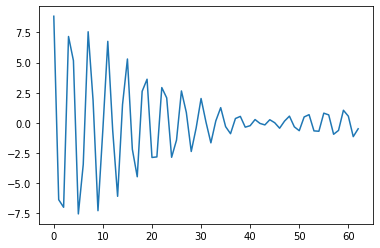

In [4]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = synthesize(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x_synth[0]))

#np.max(np.real(x_synth))

> Simple Noisless Signal with One Sinusoid and vibrato Effect

In [5]:
N_vibr0 = 2**9-1

delta_vibr0 = np.array([0])

f_vibr0 = np.array([0.3])

a_vibr0 = np.array([2])

phi_vibr0 = np.array([0])

vibrato0 = synthesize(N_vibr0, delta_vibr0, f_vibr0, a_vibr0, phi_vibr0, 0.02, 5, 0, 0)

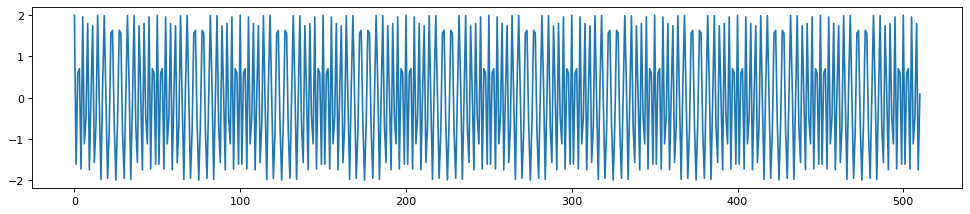

In [6]:
plt.figure(figsize=(15, 3), dpi=80)

plt.plot(np.real(vibrato0[0]))
plt.show()


In [7]:
fs_vibr0 = 1000

sd.play(np.real(vibrato0[0]), fs_vibr0)

print("The length of the signal is", N_vibr0/fs_vibr0, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr0, fs_vibr0)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato0[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr0, data.astype(np.int16))

The length of the signal is 0.511 seconds.


> Noisless Signal with Eight Sinusoids and vibrato Effect

In [8]:
N_vibr1 = 2**11-1

K_vibr1 = 8

f0_vibr1 = 0.06
f_vibr1 = f0_vibr1*np.arange(1,K_vibr1+1)

a_vibr1 = np.array([0.00807193, 0.09748246, 0.02404544, 0.04275309, 0.02482811,
       0.08778044, 0.00470351, 0.03118916])

delta_vibr1 = -0.0001*np.random.rand(K_vibr1)

phi_vibr1 = np.array([1.76348603, 1.20411769, 0.76158339, 1.35157899, 0.36247392,
       1.44086579, 1.73647764, 1.98131046])

vibrato1 = synthesize(N_vibr1, delta_vibr1, f_vibr1, a_vibr1, phi_vibr1, 0.003, 10, 0, 0)

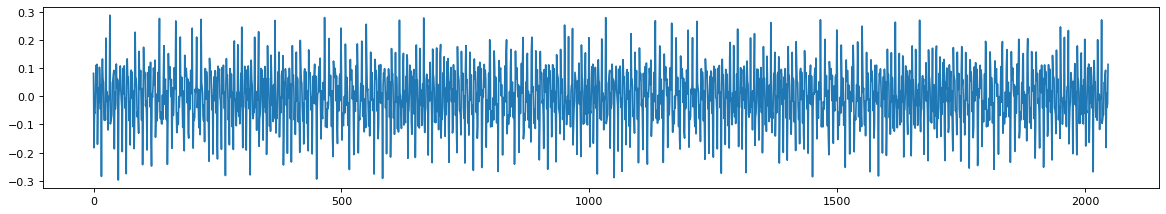

In [9]:
plt.figure(figsize=(18, 3), dpi=80)

plt.plot(np.real(vibrato1[0]))

plt.show()

In [11]:
fs_vibr1 = 1000

sd.play(np.real(vibrato1[0]), fs_vibr1)

print("The length of the signal is", N_vibr1/fs_vibr1, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr1, fs_vibr1)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato1[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr1, data.astype(np.int16))

The length of the signal is 2.047 seconds.


In [12]:
f0_vibr1*fs_vibr1

60.0

> Noisless Signal with Eight Sinusoids (Pink Noise and SNR = 39 dB)

SNR = 38.58869223195649 dB


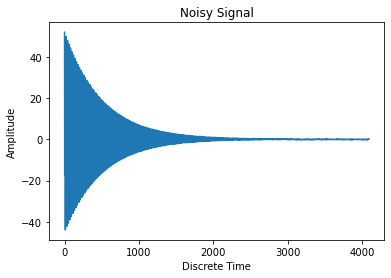

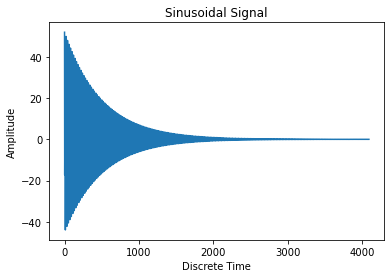

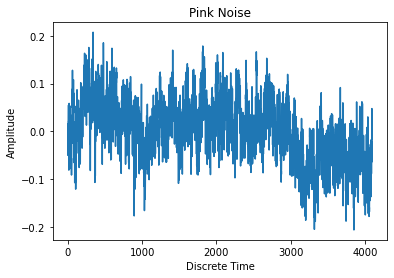

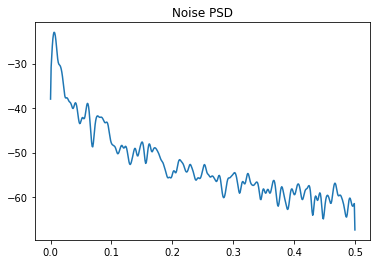

In [25]:
N_synth2 = 2**12-1

K_synth2 = 8

#f_synth2 = 0.48*np.random.rand(0,K_synth2) + 0.1*np.ones(K_synth2) 

#a_synth2 = 19*np.random.rand(0,K_synth2) + np.ones(K_synth2) 

f_synth2 = 0.05*np.arange(1,K_synth2+1)

a_synth2 = np.array([18, 15, 13, 11, 8, 5, 4, 3])

delta_synth2 = -0.002*np.ones([K_synth2])

phi_synth2 = np.array([0, 1.5, 0, 1, 0, 1.5, 0, 1])

# synthesised signal
x_synth2 = synthesize(N_synth2, delta_synth2, f_synth2, a_synth2, phi_synth2, 0, 0, 2, 70)

print("SNR =", x_synth2[3], "dB")

plt.figure()
plt.plot(np.real(x_synth2[0]))
plt.title('Noisy Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(np.real(x_synth2[1]))
plt.title('Sinusoidal Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(x_synth2[2])
plt.title('Pink Noise')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
plt.show()


plt.figure()
plt.title("Noise PSD")
freq_synth2, PSD_noise_synth2 = signal.welch(x_synth2[2], nfft=1024)
plt.plot(freq_synth2, 20*np.log10(PSD_noise_synth2))
plt.show()


In [14]:
fs_synth2 = 1000

sd.play(np.real(x_synth2[0]), fs_synth2)

print("The length of the signal is", N_synth2/fs_synth2, "seconds.")

t = np.linspace(0., N_synth2/fs_synth2, fs_synth2)
amplitude = 0.01*np.iinfo(np.int16).max
data  = amplitude*np.real(x_synth2[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("noisy2.wav", fs_synth2, data.astype(np.int16))

The length of the signal is 4.095 seconds.


> ## Signal Treatment

> #### Pre-emphasis

In [15]:
def preemphasize(sig : np.ndarray, b = np.array([1, -0.95])):
    # input
        # sig: the input signal
        # b = = np.array([1, -0.95]) # coefficients recommended by the prof, change if needed
        N = len(sig)
        Nfft = nextpow2(N)

        a = np.ones(2)
        preemph_sig = signal.lfilter(b, a, sig)

        PSD_sig, freq = plt.psd(sig, )
        PSD_preemph_sig, _ =  plt.psd(preemph_sig, Nfft)

        return preemph_sig, freq, PSD_sig, PSD_preemph_sig

> #### Filter Bank and Decimation

We will try signal.stft which is equivalent to a filter bank + decimation (see the test codes below).

> Testing "signal.stft"

In [16]:
fs_stft = 1.0
window_name ='hann'
n_fft = 16
m = n_fft // 4 # window length
step = 2

sig = np.real(x_synth1[0])
freqs_x, times_x, x_arr = sig.stft(sig, fs=fs_stft, window=window_name,
    nperseg=m, nfft=n_fft)
print()

for k in range()
times_sig = np.arange(N_synth1) * fs_stft

SyntaxError: invalid syntax (3514214574.py, line 12)

We have a problem here, the subbands cover the same 4 frequencies of the input signal and leave out the other 4 (see figure below).

In [17]:
k0 = 6 # n# of band
plt.figure()
plt.plot(times_sig, sig) # / np.max(np.abs(sig)))
plt.plot(times_x, np.real(x_arr[k0])) #/ np.max(np.abs(x_arr)))
plt.title('Input signal (in blue) and the 6th\ncomponent of the filter bank (in yellow)')
plt.show()

reconstruction = np.zeros(len(x_arr[0]))
for k in range(len(x_arr)):
    reconstruction += np.real(x_arr[k])

plt.figure()
plt.plot(times_x, reconstruction)
plt.title('Reconstructed Signal (sum of all compoenents)')
plt.show()

plt.figure()

plt.plot(signal.welch(sig)[0], signal.welch(sig)[1])

for k in range(len(x_arr)):
    component = np.real(x_arr[k])
    plt.plot(signal.welch(component)[0], signal.welch(component)[1])

plt.title('PSD of original signal (in blue)\nand of the components (other colors)')
plt.show()

NameError: name 'times_sig' is not defined

<Figure size 432x288 with 0 Axes>

> #### Noise Whitening

In [18]:
# (can be applied to the original signal and also to the signals filtered with subbands)
def whiten(x : np.ndarray, smoothing_order : int, AR_order : int): # add input??
    # input
        # x: the input signal FOR EACH FREQUENCY BAND
        # smoothing_order: at least two times the length of the PSD's principal lobe (can be done visually)
        # AR_order: ~ 10
    
    N = len(x)
    Nfft = nextpow2(N)
    
    # Step 1: signal's power spectral density
    freq, PSD_x = signal.welch(x, nfft = Nfft) #return_onesided = False
    #PSD_x, freq = plt.psd(x, Nfft)


    # Step 2: estimating the noise's PSD with a median filter (smoothing the signal's PSD)
    PSD_noise = scipy.ndimage.median_filter(PSD_x, smoothing_order) # smoothed PSD = estimation of the noise PSD   

    # Step 3: calculating the autocovariance of the noise
    AC = np.real(np.fft.ifft(PSD_noise, Nfft))                     # autocovariance (vector) of the noise
    print(AC)
    R = toeplitz(AC[:AR_order-1],AC[:AR_order-1])   # coefficients matrix of the Yule-Walker system
                                                    # = autocovariance matrix with the last row and last column removed
    r = AC[1:AR_order].T               # the constant column of the Yule-Walker system
    B = - pinv(R) @ r           # the AR coefficients (indices 1, ..., N-1)
    B = np.insert(B, 0, 1)      # the AR coefficients (indices 0, ..., N-1)

    # Step 4: applying the corresponding FIR to the signal's PSD to obtain the whitened signal
    # The FIR is the inverse of the AR filter so the coefficients of the FIR's numerator
    # are the coefficients of the AR's denominator, i.e. the array B
    # denominator co-eff of the FIR's transfer function is 1
    x_white = signal.lfilter(B, [1], x)

    # Step 5: re-estimating the noise, now for the white signal
    _, PSD_x_white = signal.welch(x_white, nfft = Nfft)
    #PSD_x_white, freq = plt.psd(x_white, Nfft)
    PSD_noise_white = scipy.ndimage.median_filter(PSD_x_white, smoothing_order)

    return x_white, freq, PSD_x, PSD_noise, PSD_x_white, PSD_noise_white

> Testing "whiten"

[ 0.01314691  0.00827191  0.00186822 ... -0.00065461  0.00186822
  0.00827191]
The minimum value for the smoothing order is 131.136


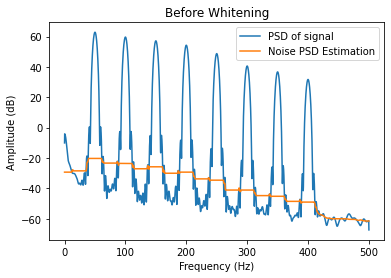

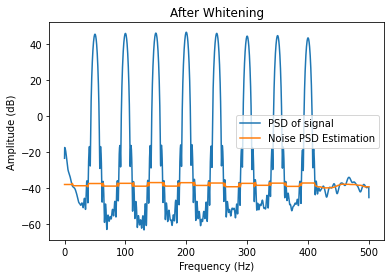

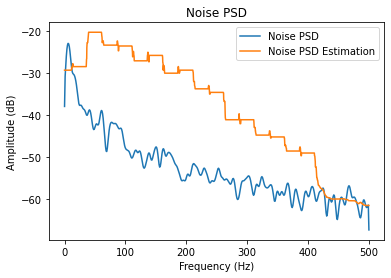

In [27]:
x_white2, freq2_norm, PSD_x2, PSD_noise2, PSD_x_white2, PSD_noise_white2 = whiten(np.real(x_synth2[0]), 200, 15)

print('The minimum value for the smoothing order is', 4*0.016*len(freq2_norm))

freq2 = fs_synth2*freq2_norm

plt.figure()
plt.title('Before Whitening')
plt.plot(freq2, 20*np.log10((PSD_x2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

plt.figure()
plt.title('After Whitening')
plt.plot(freq2, 20*np.log10((PSD_x_white2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise_white2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()


plt.figure()
plt.title("Noise PSD")
plt.plot(fs_synth2*freq_synth2, 20*np.log10(PSD_noise_synth2), label = 'Noise PSD')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

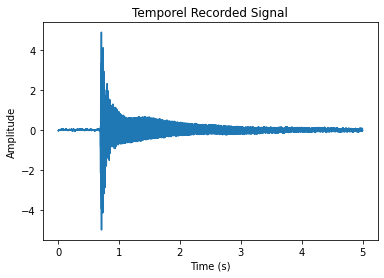

In [28]:
# Loading config from config files
conf_dir = pathlib.Path('./config/expr/')
data_dir = pathlib.Path('../data/expr/2022_01_27')
#
log_path = conf_dir / 'log_config.json'
conf_path = conf_dir / 'analysis_config.json'
data_path = data_dir / 'FirstStringGuitar_CopperWired01mm_18cmFromBridge_1.mat'

log = load_data_json(log_path)
conf = load_data_json(conf_path)
expr_data = load_analysis(data_path, conf)

# see expr/util.py for details on what's inside expr_data
mic = expr_data["temporal"]["mic"]["whole"]
times = expr_data["times"]["whole"]

plt.figure()
plt.title("Temporel Recorded Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(times, mic)
plt.show()

In [29]:
fs_mic = int(1/(times[1]-times[0]))

sd.play(mic[35000:], fs_mic)

[0.04527122 0.03802573 0.02403362 ... 0.01356754 0.02403362 0.03802573]
The smoothing order must be at least 2097.216


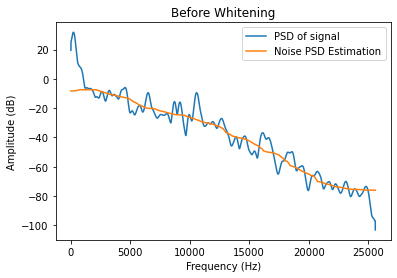

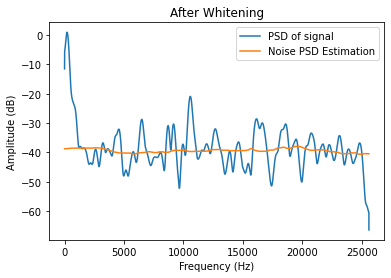

In [32]:
mic_white, freq_mic, PSD_mic, PSD_noise_mic, PSD_mic_white, PSD_noise_mic_white = whiten(mic[35000:70000], 10000, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_mic))

freq_mic *= fs_mic

plt.figure()
plt.title('Before Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure()
plt.title('After Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic_white)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()

> ## ESPRIT

In [ ]:
def ESPRIT(x : np.ndarray, n : int, K : int):
    # input
        # x: input signal
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: number of searched sinusoids

        # (n-K : noise space dimension)

    # output
        # delta: array of damping factors
        # f: array of frequencies

    N = len(x)          # signal's length
    l = N - n + 1       # number of columns of the Hankel matrix
                        # Not needed for the 'hankel' function but used in the formula of R_XX  

    X = hankel(x[:n], x[n-1:])      # Hankel matrix

    R_XX = 1/l * X @ X.conj().T             # correlation matrix
    U1, Lambda, U2 = np.linalg.svd(R_XX)
    W = U1[:n, :K]                          # signal space matrix
    
    W_down = W[:-1]
    W_up = W[1:]
    phi = (np.linalg.pinv(W_down)) @ W_up
    eigenvalues, eigenvectors = np.linalg.eig(phi)
    
    delta = np.log(np.abs(eigenvalues))         # damping factors
    f = (1/(2*np.pi)) * np.angle(eigenvalues)   # frequencies

    return delta, f


> ## Least Squares

In [ ]:
def LeastSquares(x : np.ndarray, delta : np.ndarray, f : np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # f: array of frequencies

    # output
        # alpha: array of complex amplitudes
        # a: array of real amplitudes
        # phi: array of initial phases

    N = len(x)                  # signal's length
    t = np.arange(N)            # array of discrete times
    s = delta + 2j*np.pi*f      # log of the pole
    VN = np.exp(np.outer(t,s))  # Vandermonde matrix of dimension N
    
    alpha = np.linalg.pinv(VN)@x
    a = abs(alpha)
    phi = np.angle(alpha)
    
    return alpha, a, phi

> Testing EPRIT and LeastSquares

In [ ]:
delta_an, f_an = ESPRIT(x_synth[0], 32, 2)

alpha_an, a_an, phi_an = LeastSquares(x_synth[0], delta_an, f_an)

#EdB_an = Energy(x_synth, delta_an, a_an)

print(delta_an, f_an, alpha_an, a_an, phi_an)#, EdB_an)


> ## Energy

In [ ]:
def Energy(x: np.ndarray, delta: np.ndarray, a: np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # a: array of real amplitudes

    # output
        # EdB: array of energies

    
    N = len(x)              # signal's length
    times = np.arange(N)    # array of discrete times

    K = len(delta)          # number of sinusoids
    E = np.zeros(K)

    for k in range(K):      # calculating the energy of each sinusoid
        e_k = 0
        for t in times:
            e_k += np.exp(2*delta[k]*t)     # the contribution of delta
        E[k] = a[k]**2 * e_k                # the energy of the kth sinusoid

    Emax = max(E)
    EdB = 10*np.log(E/Emax)     # Energy in dB

    return EdB


> ## ESTER

In [ ]:
def ESTER(x : np.ndarray, n : int, K : int):
    # x: input signal
    # n: n: number of lines in the Hankel matrix S
    # K: ?

    # calculating the inverse error function
    N = len(x)
    l = N-n+1
    X = hankel(x[:n], x[n-1:N])
    XH = X.conj().T
    Rxx = 1/l*X*XH
    U1, lam, U =  np.linalg.svd(Rxx)
    norm_E = []
    for i in range(K):
        W = U1[: n, :i]
        W_down = W[0:n-1,:]
        W_up = W[1:n,:]
        Phi = np.dot(np.linalg.pinv(W_down),(W_up))
        E = W_up - np.dot(W_down, Phi)
        Valeur,_,_ = np.linalg.svd(E)
        norm_E = max(Valeur)  # not sure here
    return norm_E

> ## ESPRIT BY BLOCKS
(Contains ESPRIT and LeastSquares)

In [ ]:
def blocks(x_full : np.ndarray, window_length : float, hop_size : float, sampling_rate : int, n : int, K : int):
    # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids

    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hop size (in samples)
    I = int((N_full-N)/h)

    delta   = np.zeros((I,K))
    f       = np.zeros((I,K))
    alpha   = np.zeros((I,K), dtype=complex)
    a       = np.zeros((I,K))
    phi     = np.zeros((I,K))
    # EdB     = np.zeros((I,K))

    for i in tqdm(range(I)):

        x_i = x_full[h*i:h*i+N]     # ith truncated signal

        delta[i], f[i] = ESPRIT(x_i, n, K)
        alpha[i], a[i], phi[i] = LeastSquares(x_i, delta[i], f[i])
        # EdB[i] = Energy(x[i], delta[i], a[i])

    return delta, f, alpha, a, phi #, EdB

> Testing "blocks" (with a vibrato)

In [ ]:
delta00, f00, alpha00, a00, phi00 = blocks(vibrato0[0][:200], 0.035, 0.020, fs_vibr0, 32, 1)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr0, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

In [ ]:
delta00, f00, alpha00, a00, phi00 = blocks(vibrato1[0][:200], 0.035, 0.020, fs_vibr1, 32, 8)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr1, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

In [ ]:
delta_mic, f_mic, alpha_mic, a_mic, phi_mic = blocks(mic_white, 0.030, 0.020, fs_mic, 32, 30)

print( 'Frequencies:\n', f_mic*fs_mic, '\n\n- Damping factors:\n', delta_mic, '\n\n- Complex Amplitudes:\n', alpha_mic, '\n\n- Amplitudes:\n', a_mic, '\n\n- Intial Phases:\n', phi_mic )

In [ ]:
# Another code for filter bank and decimation (incomplete)

center_freqs = np.arange(100, 3000, 100) # à nous de définir selon le signal
def filter_bank(sig : np.ndarray, center_freqs : np.ndarray, fe : float):
    #input
       #sig
       #center_freqs : centered frequencies in filter banks
       #fe : sampling frequency


    #filter banks
    #PSD_sig = plt.psd(sig)
    nb_bands = len(center_freqs)
    #crossover_gain = 10**(-3/20) # cross at -3db of gain for the adjacent bands

    #band edges, frequencies
    band_edges = np.zeros((nb_bands,2))
    #band_edges [:,0] = center_freqs -  
    #band_edges [:,1] = center_freqs +   

    h = [] #impulse response 
    sig_list = []  #Roy: I suggest that we use an numpy array
    for i in range(nb_bands):
       b, a = signal.butter(nb_bands, [band_edges[i,0],band_edges[i,1]], btype = 'bandpass',analog=False, fs=fe,output='SOS')
       #w, H = signal.sosfreqz(h[i], worN=2000,fs=fe)  #Compute the frequency response of a digital filter in SOS format     
       sig_list.append(lfilter(b, a, sig))
   
    return sig_list

### Loading experimental data analysis